Model Evaluation:
              precision    recall  f1-score   support

    negative       0.93      0.95      0.94       783
     neutral       0.99      0.98      0.99      2937
    positive       0.97      0.98      0.97      1655

    accuracy                           0.98      5375
   macro avg       0.96      0.97      0.97      5375
weighted avg       0.98      0.98      0.98      5375

Model and vectorizer saved successfully.
Training Accuracy: 0.9810
Test Accuracy: 0.9756


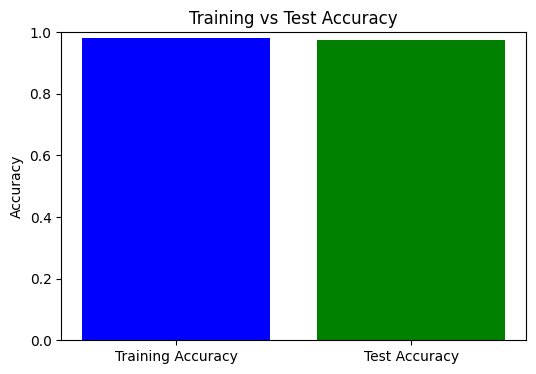

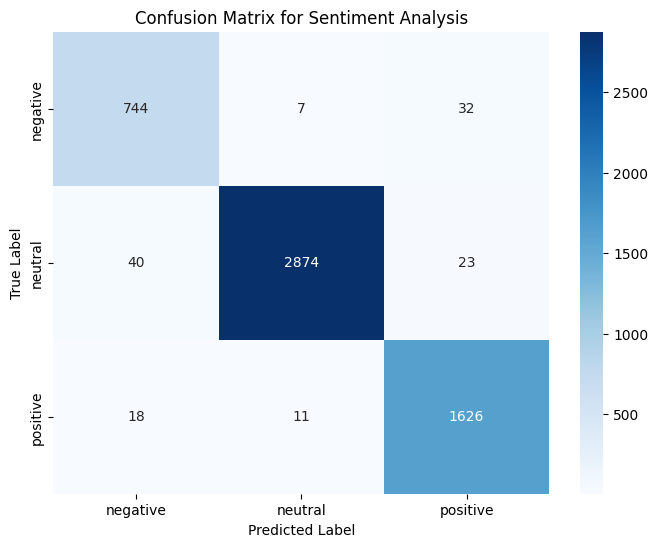

In [1]:
import pandas as pd
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the dataset
file_path = "data/preprocessed-data/bitext_cleaned.csv"
df = pd.read_csv(file_path)

# Initialize VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to label sentiment using VADER
def label_sentiment(text):
    if not isinstance(text, str):
        return "neutral"
    score = analyzer.polarity_scores(text)
    compound_score = score['compound']
    if compound_score >= 0.05:
        return "positive"
    elif compound_score <= -0.05:
        return "negative"
    else:
        return "neutral"

# Apply sentiment labeling to the 'instruction' column
df['sentiment'] = df['instruction'].apply(label_sentiment)

# Prepare data for training
X = df['instruction']
y = df['sentiment']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert text to TF-IDF features
tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Train a Logistic Regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train_tfidf, y_train)

# Evaluate the model
y_pred = model.predict(X_test_tfidf)
print("Model Evaluation:")
print(classification_report(y_test, y_pred))

# Save the TF-IDF vectorizer and model
with open('model/tfidf_vectorizer_user.pkl', 'wb') as f:
    pickle.dump(tfidf, f)
with open('model/sentiment_model_user.pkl', 'wb') as f:
    pickle.dump(model, f)
print("Model and vectorizer saved successfully.")

# Hàm vẽ Learning Curve
def plot_learning_curve(estimator, X, y, title="Learning Curve", cv=5, n_jobs=None, train_sizes=np.linspace(0.1, 1.0, 10)):
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.xlabel("Training Examples")
    plt.ylabel("Score")

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='accuracy'
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    plt.show()

# Hàm vẽ Ma trận nhầm lẫn
def plot_confusion_matrix(y_true, y_pred, labels, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Tính và vẽ Training Accuracy
train_accuracy = accuracy_score(y_train, model.predict(X_train_tfidf))
test_accuracy = accuracy_score(y_test, y_pred)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Vẽ biểu đồ cột so sánh Training và Test Accuracy
plt.figure(figsize=(6, 4))
plt.bar(['Training Accuracy', 'Test Accuracy'], [train_accuracy, test_accuracy], color=['blue', 'green'])
plt.ylim(0, 1)
plt.title("Training vs Test Accuracy")
plt.ylabel("Accuracy")
plt.show()

# Vẽ Ma trận nhầm lẫn
unique_labels  = np.unique(y)
plot_confusion_matrix(y_test, y_pred, labels=unique_labels, title="Confusion Matrix for Sentiment Analysis")